In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("../data/raw_data/bank_marketing_dataset.csv")

In [3]:
df = df.drop(['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','duration','campaign','previous','subscribed', 'pdays', 'default'], axis=1)

In [4]:
df["combined_education"] = df["education"].apply(lambda x: "basic" if x in set({"basic.4y", "basic.6y", "basic.9y"}) else x)
df["job"] = df["job"].apply(lambda x: "high" if x in set({"admin.", "technician", "management", "entrepreneur", "self-employed"}) else "low")

In [5]:
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,combined_education
0,56,low,married,basic.4y,no,no,telephone,may,mon,nonexistent,basic
1,57,low,married,high.school,no,no,telephone,may,mon,nonexistent,high.school
2,37,low,married,high.school,yes,no,telephone,may,mon,nonexistent,high.school
3,40,high,married,basic.6y,no,no,telephone,may,mon,nonexistent,basic
4,56,low,married,high.school,no,yes,telephone,may,mon,nonexistent,high.school


In [6]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df[["job", "marital", "combined_education", "contact", "month", "day_of_week", "housing", "loan"]]).toarray()
encoded_personal_info = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(["job", "marital", "combined_education", "contact", "month", "day_of_week", "housing", "loan"]))
encoded_personal_info = pd.concat([df, encoded_personal_info], axis=1)
encoded_personal_info = encoded_personal_info.drop(["job", "marital", "combined_education", "contact", "month", "day_of_week", "poutcome", "housing_unknown",
                                                        "loan_unknown", "education", "loan_no", "contact_cellular", "housing_no", "job_low"], axis=1)
encoded_personal_info["housing"] = encoded_personal_info["housing"].apply(lambda x: 1 if x == 'yes' else 0)
encoded_personal_info["loan"] = encoded_personal_info["loan"].apply(lambda x: 1 if x == 'yes' else 0)

In [7]:
housing_df = encoded_personal_info[encoded_personal_info.housing != "unknown"]
housing_train = housing_df.drop(["housing", "loan", "housing_yes"], axis=1)
housing_label = housing_df["housing"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(housing_train, housing_label, test_size=0.2, random_state=1)

In [9]:
np.random.seed(seed=0)
dt = RandomForestClassifier(class_weight='balanced', criterion='gini', max_features='log2', min_samples_leaf=4, n_estimators=200, max_depth=10, min_samples_split=2)
dt_model = dt.fit(X_train,y_train)
housing_pred = dt_model.predict(X_test)

precision = precision_score(y_test, housing_pred)
recall = recall_score(y_test, housing_pred)
f1 = f1_score(y_test, housing_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1_score: {f1:.2f}")

Precision: 0.57
Recall: 0.60
F1_score: 0.58


In [10]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)
top_n = 2
top_features = feature_importances.iloc[:top_n]['Feature'].tolist()

                                   Feature  Importance
0                                      age    0.265596
12                       contact_telephone    0.132972
28                                loan_yes    0.084514
17                               month_jun    0.049359
1                                 job_high    0.038102
3                          marital_married    0.028915
25                         day_of_week_thu    0.026949
4                           marital_single    0.026472
24                         day_of_week_mon    0.024516
7           combined_education_high.school    0.024346
27                         day_of_week_wed    0.024094
26                         day_of_week_tue    0.023783
20                               month_nov    0.023383
23                         day_of_week_fri    0.023266
10    combined_education_university.degree    0.023153
2                         marital_divorced    0.022159
6                 combined_education_basic    0.022115
9   combin

In [11]:
np.random.seed(seed=0)
X_train_h = X_train[top_features]
X_test_h = X_test[top_features]
dt = RandomForestClassifier(class_weight='balanced', criterion='gini', max_features='log2', min_samples_leaf=4, n_estimators=200, max_depth=10, min_samples_split=2)
dt_model = dt.fit(X_train_h,y_train)
housing_pred = dt_model.predict(X_test_h)

precision = precision_score(y_test, housing_pred)
recall = recall_score(y_test, housing_pred)
f1 = f1_score(y_test, housing_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1_score: {f1:.2f}")

Precision: 0.56
Recall: 0.65
F1_score: 0.60


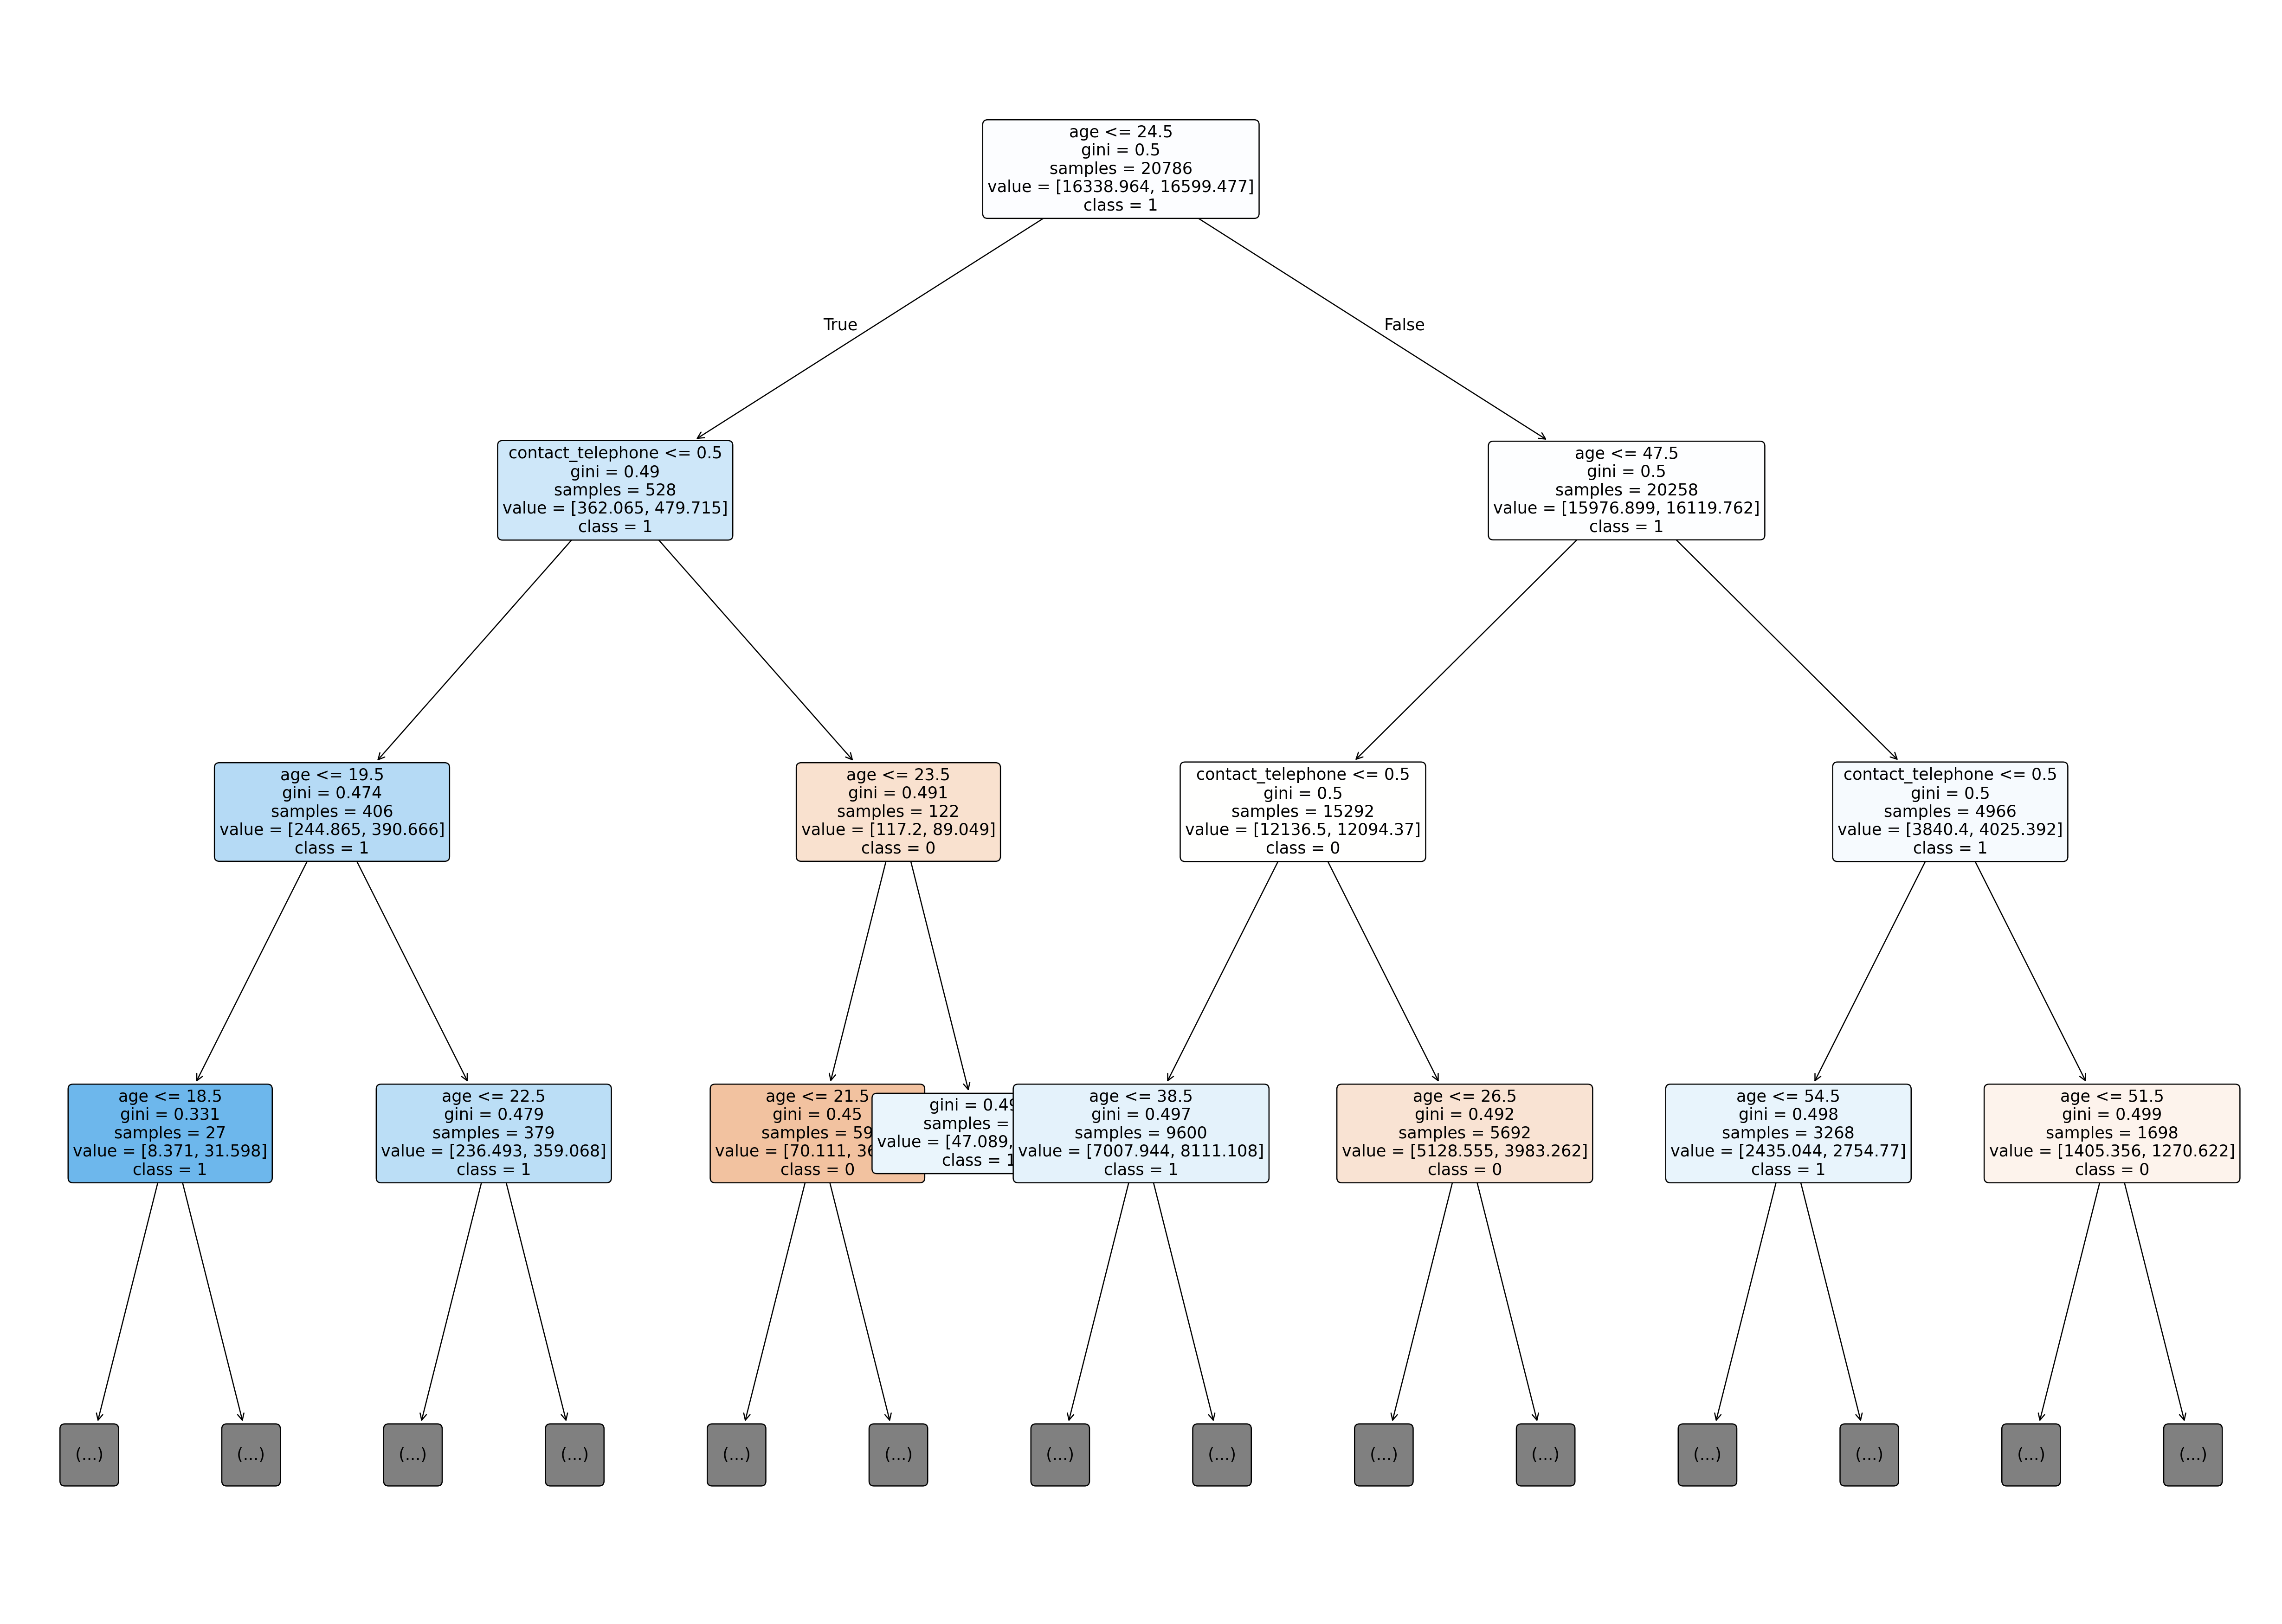

In [12]:
important_tree = dt_model.estimators_[0]

plt.figure(figsize=(35, 25), dpi=180)  
plot_tree(
    important_tree,
    feature_names=X_train_h.columns,
    class_names=[str(i) for i in np.unique(y_train)],
    filled=True,
    rounded=True,
    max_depth=3, 
    fontsize=14  
)
plt.show()


In [13]:
loan_df = encoded_personal_info[encoded_personal_info.loan != "unknown"]
loan_train = loan_df.drop(["housing", "loan", "loan_yes"], axis=1)
loan_label = loan_df["loan"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(loan_train, loan_label, test_size=0.2, random_state=1)

In [15]:
np.random.seed(seed=0)
dt = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=300)
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
dt_model = dt.fit(X_train_resampled, y_train_resampled)
loan_pred = dt_model.predict(X_test)
f1 = classification_report(y_test, loan_pred, output_dict=True)['weighted avg']['f1-score']
micro_f1 = f1_score(y_test, loan_pred, average='micro')

print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"F1_score: {f1:.2f}")
#print("Classification Report:\n", classification_report(y_test, loan_pred))
print('Decision Tree accuracy for training set: %f' % dt_model.score(X_train, y_train))
print('Decision Tree accuracy for test set: %f' % dt_model.score(X_test, y_test))

Micro F1-Score: 0.7908
F1_score: 0.77
Decision Tree accuracy for training set: 0.873050
Decision Tree accuracy for test set: 0.790847


In [16]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)
top_n = 2
top_features = feature_importances.iloc[:top_n]['Feature'].tolist()
print(top_features)

                                   Feature  Importance
0                                      age    0.272522
28                             housing_yes    0.118069
1                                 job_high    0.062057
12                       contact_telephone    0.062018
26                         day_of_week_tue    0.030340
19                               month_may    0.030185
24                         day_of_week_mon    0.029731
25                         day_of_week_thu    0.028708
23                         day_of_week_fri    0.028611
27                         day_of_week_wed    0.027847
16                               month_jul    0.026961
7           combined_education_high.school    0.026054
3                          marital_married    0.025803
6                 combined_education_basic    0.025104
10    combined_education_university.degree    0.024911
2                         marital_divorced    0.023948
4                           marital_single    0.021808
9   combin

In [17]:
np.random.seed(seed=0)
X_train_resampled_l = X_train_resampled[top_features]
X_test_l = X_test[top_features]
dt = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=300)
dt_model = dt.fit(X_train_resampled_l, y_train_resampled)
loan_pred = dt_model.predict(X_test_l)
f1 = classification_report(y_test, loan_pred, output_dict=True)['weighted avg']['f1-score']
micro_f1 = f1_score(y_test, loan_pred, average='micro')

print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"F1_score: {f1:.2f}")
#print("Classification Report:\n", classification_report(y_test, loan_pred))


Micro F1-Score: 0.6763
F1_score: 0.71


In [18]:
X_train_resampled.head()

,age,job_high,marital_divorced,marital_married,marital_single,marital_unknown,combined_education_basic,combined_education_high.school,combined_education_illiterate,combined_education_professional.course,...,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,housing_yes
0,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,58,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,32,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,26,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,48,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [19]:
dt_model.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       min_samples_split=5, random_state=209652396)

In [20]:
important_tree = dt_model.estimators_[0]

plt.figure(figsize=(50, 35), dpi=280)  
plot_tree(
    important_tree,
    feature_names=X_train_resampled_l.columns,
    class_names=[str(i) for i in np.unique(y_train_resampled)],
    filled=True,
    rounded=True,
    max_depth=3, 
    fontsize=14  
)
plt.show()